# Ochlazování kapaliny

- Vychází z řešení laboratorní úlohy [ochlazování kapaliny](https://physics.mff.cuni.cz/vyuka/zfp/zadani/192) od Samuela Jankovycha. NEKOPÍRUJTE TOTO ŘEŠENÍ! Slouží pouze jako příklad, jak provést analýzu dat.

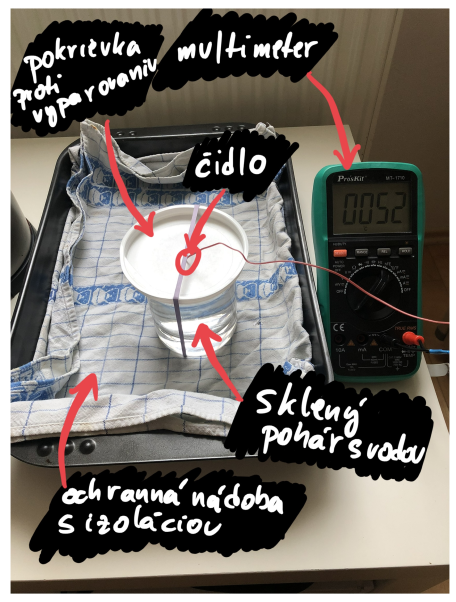

Jednoduchý vzorec popisující teplotu $\vartheta$ kapaliny jako funkci času $t$ je dán:

$$\frac{\vartheta(t)-\vartheta_{\infty}}{\vartheta_0-\vartheta_{\infty}} = e^{-\frac{t}{\tau}}$$

| Symbol | Popis |
|---|---|
| $\vartheta(t)$ | Teplota kapaliny v čase $t$ |
| $\vartheta_{\infty}$ | Teplota okolí |
| $\vartheta_0$ | Počáteční teplota kapaliny |
| $\tau$ | Časová konstanta procesu ochlazování |

Úkol: Určete časovou konstantu $\tau$ pro proces ochlazování.

Postup:

1. Změřte $\vartheta_{\infty}$, $\vartheta_0$.

2. Změřte $\vartheta(t)$ v různých časových bodech $t$.

3. Pro každý čas $t$ vypočítejte $\Theta(t) = \frac{\vartheta(t)-\vartheta_{\infty}}{\vartheta_0-\vartheta_{\infty}}$.

4. Fitujte exponenciální funkci $e^{-\frac{t}{\tau}}$ na data $\Theta(t)$ vs. $t$ pro určení $\tau$.



In [ ]:
# 1.
# Reprezentujte theta_0 a theta_inf jako objekty `ufloat`.
from uncertainties import ufloat
theta_0 = ufloat(90.0, 5.9)
theta_inf = ufloat(24.2, 0.3)

In [ ]:
# 2.
# Načtěte `data/no_evaporation_no_ventilator.csv` pomocí pandas
import pandas as pd
data = pd.read_csv('data/no_evaporation_no_ventilator.csv', delimiter = ',')

# Převeďte t ze sekund na minuty
t = data['t'] / 60

# Reprezentujte theta jako numpy pole objektů `ufloat`.
from uncertainties import unumpy
theta = unumpy.uarray(data['theta'], 5 + data['theta'] * 0.01)  # Předpokládáme 1% nejistotu plus pevnou nejistotu 5 stupňů

In [ ]:
# 3.
# Vypočítejte Theta pomocí vzorce uvedeného v notebooku.
Theta = (theta - theta_inf) / (theta_0 - theta_inf)
print(Theta)

In [ ]:
# 4.
# Fitujte exponenciální funkci na data Theta vs. t pro určení tau.
import scipy.optimize
import numpy as np

def exponential(t, tau):
    return np.exp(-t / tau)

# Proveďte fit.
popt, pcov = scipy.optimize.curve_fit(exponential, 
                                      t,
                                      unumpy.nominal_values(Theta), 
                                      sigma = unumpy.std_devs(Theta), 
                                      absolute_sigma = True)

# Reprezentujte tau jako objekt `ufloat`, včetně nejistoty z fitu a dodatečné systematické nejistoty 9 %.
# (Nevím, odkud těch 9 % pochází, ale bylo to zmíněno ve zprávě, takže to zahrnu.)
tau = ufloat(popt[0], np.sqrt(pcov[0,0] + (0.09 * popt[0]) ** 2))  # Přidání 9% systematické nejistoty k tau
print("Časová konstanta tau:", tau)



Můžeme přistoupit k diskusi o významu časové konstanty $\tau$. Je dána detailními fyzikálními vlastnostmi systému:

$$\tau = \frac{m_1 c_{p1} + m_2 c_{p2}}{S \alpha}$$

| Symbol | Hodnota | Popis |
|---|---|---|
| $m_1$ | $270 \pm 1\ \mathrm{g}$ | Hmotnost kapaliny |
| $c_{p1}$ | $4.2\ \mathrm{J} \mathrm{g}^{-1} \mathrm{K}^{-1}$ | Měrná tepelná kapacita kapaliny |
| $m_2$ | $393 \pm 1\ \mathrm{g}$ | Hmotnost nádoby |
| $c_{p2}$ | $0.75\ \mathrm{J} \mathrm{g}^{-1} \mathrm{K}^{-1}$ | Měrná tepelná kapacita nádoby |
| $S$ | $210 \pm 0.7\ \mathrm{cm}^2$ | Povrch nádoby v kontaktu s okolím |
| $\alpha$ | | Součinitel přestupu tepla mezi nádobou a okolím |

Konečným cílem tohoto experimentu je určit $\alpha$ a vypočítat celkové teplo ztracené kapalinou.

In [ ]:
# Vypočítejte alpha ve W/m^2
m_1 = ufloat(270, 1)         # hmotnost kapaliny v gramech
c_p1 = 4.2                   # měrná tepelná kapacita kapaliny v J/g/K
m_2 = ufloat(393, 1)         # hmotnost nádoby v gramech
c_p2 = 0.75                  # měrná tepelná kapacita nádoby v J/g/K
S = ufloat(210, 0.7) / 1.e4  # povrch nádoby v m^2
alpha = (m_1 * c_p1 + m_2 * c_p2) / (tau * 60 * S)
print("Součinitel přestupu tepla alpha:", alpha)

In [ ]:
# Vypočítejte ztracené teplo
Q = (m_1 * c_p1) * (theta_0 - theta[-1])
print("Ztracené teplo Q:", Q)

In [ ]:
# Vykreslete graf Theta vs. t s chybovými úsečkami a fitovanou exponenciální křivkou.
import matplotlib.pyplot as plt
plt.errorbar(t, unumpy.nominal_values(Theta), yerr = unumpy.std_devs(Theta), fmt = 'o', label = 'Data', color = 'black')
t_fit = np.linspace(0, max(t), 100)
Theta_fit = exponential(t_fit, *popt)
plt.plot(t_fit, Theta_fit, label = 'Fit', color = 'red')
plt.xlabel(r'$t$ [min]')
plt.ylabel(r'$\Theta(t)$')
plt.legend()
plt.show()

# Závěrečné poznámky

- Ve svém řešení provedl Samuel Jankovych pět měření $\vartheta(t)$, pokaždé za různých podmínek (s víkem a bez víka, s ventilátorem a bez ventilátoru a s Dewarovou nádobou). Odpovídající data jsou uložena ve složce `data`. Tato data můžete použít k procvičení analýzy dat. Prozkoumejte, jaké fyzikální informace jsou v datech obsaženy!

- Nejistoty jsou pravděpodobně nadhodnoceny. Např. 9% dodatečná nejistota parametru $\tau$ je "ze vzduchu". Také pevná složka 5 K v nejistotě $\vartheta(t)$ je pravděpodobně příliš vysoká. Pokud by byla realistická, datové body by byly mnohem více rozptýlené; jsou téměř zarovnány na jedné křivce, jak je vidět na grafu výše.